## Sampling the double-well potential with Boltzmann generators

### Section 1. Double-well potential

In this section, 

According to the supplemntary materials of the paper, the equation of the double-well potential is $E(x, y) = ax^{4}-bx^{2}+cx+dy^{2}$
Therefore, we have:
$$\frac{\partial E}{\partial x} = 4ax^{3}-2bx+c=0, \;\frac{\partial E}{\partial y}=dy=0$$
By default, $a=1$, $b=6$, $c=1$, and $d=1$. Solving the equations above,  so the three places with a 0 derivative along with their potential are:
$(-1.7723, 0, -10.7524)$, $(0.08253, 0, 0.0417)$, and $(1.6888, 0, -7.2893)$. Accordingly, the energy difference between the wells is $3.463$.


In [1]:
import numpy as np
import potentials
import sampling
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import torch 
from torch import distributions
from torch import nn

The coordinates of the minima are: [-1.7723034076580755, 0.0] and [1.6887758209615107, 0.0].
The coordinate of the saddle point is: [0.08352758669656443, 0.0].
The energy difference between the two local minima is: 3.463.
The height of energy barrier is: 10.794.


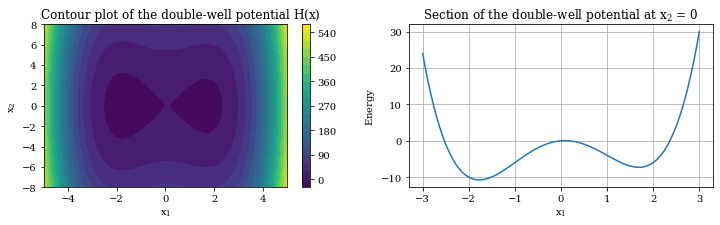

In [2]:
doublewell = potentials.DoubleWellPotential()  #  defaults = {"a": 1, "b": 6, "c": 1, "d": 1}
# another choice: a=0.25, b=1.5, c=1, d=1
doublewell.plot_samples()
print('The coordinates of the minima are: %s and %s.' % (list(doublewell.min_left), list(doublewell.min_right)))
print('The coordinate of the saddle point is: %s.' % list(doublewell.saddle))
print('The energy difference between the two local minima is: %5.3f.' % doublewell.e_diff)
print('The height of energy barrier is: %5.3f.' % doublewell.barrier)

In [17]:
from scipy.optimize import fmin
from scipy.optimize import minimize
import math

def f(x):
    x[0] ** 4 -6 * x[0] ** 2 + x[0] + x[1] ** 2

fun = lambda x: (x[0] - 1)**2 + (x[1] - 2.5)**2
fun = lambda x: x[0] ** 4 -6 * x[0] ** 2 + x[0] + x[1] ** 2

res = minimize(fun, np.array([0, 0]), method='Nelder-Mead', tol=1e-6)
res['x']   # global minimum

array([-1.77230327e+00, -1.59233418e-07])

### Section 2. Acquisition of the input dataset from Metropolis Monte Carlo simulations

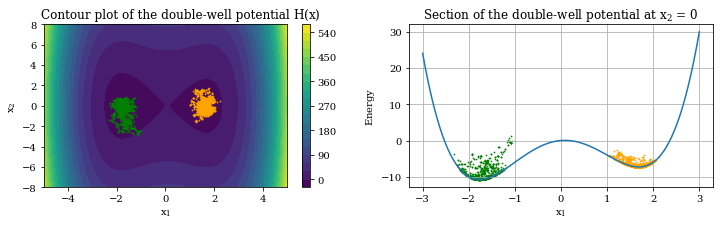

In [19]:
MCsampler1 = sampling.MetropolisSampler(doublewell, doublewell.min_left)
MCsampler1.run(doublewell.min_left, 1000)
samples1 = MCsampler1.xtraj

MCsampler2 = sampling.MetropolisSampler(doublewell, doublewell.min_right)
MCsampler2.run(doublewell.min_right, 1000)
samples2 = MCsampler2.xtraj

fig = doublewell.plot_samples(samples1)
fig = doublewell.plot_samples(samples2, fig, 'orange')

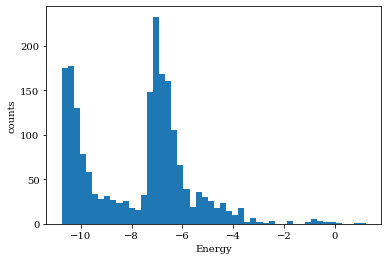

In [20]:
samples = np.concatenate((samples1, samples2))  # the training dataset
np.random.shuffle(samples) # shuffle rows of data
plt.hist(doublewell.get_energy(samples[:, 0], samples[:, 1]), bins=50)
plt.xlabel('Energy')
plt.ylabel('counts')
plt.show()

### Section 3. Training of the Boltzmann generators

In [ ]:
n_blocks = 3    # number of NVP blocks
dimension = 2   # dimensionality of the probability distributios (in real sapce and latent space)

In [21]:
n_hidden = 100  # number of nodes in each hidden layer
l_hidden = 3   # number of hidden layers 
iter1 = 100
iter2 = 100
batch_size1 = 1000 # less than 1000 does not seem to converge 
batch_size2 = 1000 
lr1 = 0.001 # could not get monotonic decrease of loss with largest learning rates when using standard gradient descent. 
lr2 = 0.001

In [20]:
# Parameter Debugging
n_hidden = 256

# Define our model (the double well potential)
dw_pars = {"a":1, "b":6, "c":1, "d":1}
#doublewell = DoubleWell()

# Define the network architecture
nets = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh()) # net s
nett = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh()) # net t
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * n_blocks).astype(np.float32)) # 6x2 matrix. len(masks) = 6 = num subblocks.
prior = distributions.MultivariateNormal(torch.zeros(dimension), torch.eye(dimension))      # so we have a total of 3 neural blocks (see fig. 1 of boltzmann generators paper)
#model = net.RealNVP(nets, nett, masks, prior, doublewell, (2,))

### Some notes about the methods used in the implementation of the Boltzmann generator

- Prior probability distribution:
    - ``prior = distributions.MultivariateNormal(torch.zeros(dimension), torch.eye(dimension)``
    - Note that our double-well potential is a 2D function, so the Gaussian distribution must be bivariate. (`dimension=2`)
    - `torch.zeros(2)`: The mean of the bivariate normal distribution, which is a 1-by-2 zero matrix in this case.
    - `torch.eye(2)`: The covariance matrix of the bivariate normal distribution, which is an 2-by-2 identity matrix.
    - To generate 500 samples from the prior distribution, use `prior.sample([500])`.
- Masking shceme for affine coupling layers:
    - `masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * n_blocks).astype(np.float32))`
    - In `__init__` function of `RealNVP` in `generator.py`, `self.mask = nn.Parameter(mask)` makes the mask as the module parameter. Note that `nn.Parameter` only takes in `torch.Tensor`. (Try printing `nn.Parameter(mask)`.)
- Scaling (`s_net`) and transformation (`t_net`) function in the coupling layers:
    - `torch.nn.Sequential`: A sequential container. Modules will be added to it in the order they are passed in the constructor. Alternatively, an ordered dict of modules can also be passed in.
    - In our case here, there are three hidden layers, which are all initialized by `nn.Linear` module, which applies a linear transofmration to the incoming data: $y = x A^{T} + b$. (Note that `nn.Linear` module automatically initializes the weights randomly.)
    - The dimensions of the input and the output of the networks should be 2, which correspond to the dimensionality of the proability distribution. Therefore, the number of input nodes of the first layer and the output node of the last layer are both 2.
    - For `s_net`, except that the last hidden layer uses hyperbolic tangent, other layers all use ReLU as the activation function. However, for `t_net`



- `self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))]) # translation function (net)`

In [65]:
A = torch.nn.ModuleList([nett() for _ in range(len(masks))])
print(A)
A[0]

ModuleList(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (2): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (3): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (4): Sequential(
    (0): Linear(in_fe

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=2, bias=True)
)

In [61]:
torch.nn.ModuleList(nett())

ModuleList(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=2, bias=True)
)

In [58]:
for _ in range(len(masks)):
    print(nett())
    print()

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=2, bias=True)
)

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=2, bias=True)
)

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=2, bias=True)
)

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=2, bias=True)
)

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_featu

Parameters to try
- Different masking schemes
- Different activation functions in each layer of the neural networks (s_net and t_net).
- Whether to use an activation function in the output layer.


### Todos
- Read RealNVP paper
- Read Boltzmann generators paper
- Prepare the second test system
- Check REMD of PLCpep7

In [37]:
type(prior)

torch.distributions.multivariate_normal.MultivariateNormal

In [18]:
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [26]:
prior.log_prob

<bound method MultivariateNormal.log_prob of MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2]))>

### Mueller Brown potential

In [25]:
aj = np.array([-1, -1, -6.5, 0.7])
bj = np.array([0, 0, 11, 0.6])
cj = np.array([-10, -10, 6.5, 0.7])
Aj = np.array([-200, -100, -170, 15])
xj = np.array([1, 0, -0.5, -1])
yj = np.array([0, 0.5, 1.5, 1])

mueller = potentials.MuellerPotential(aj, bj, cj, Aj, xj, yj)

In [26]:
def plot_contour(potential, x_range, y_range, grid = [100, 100]):
    x = np.linspace(x_range[0],x_range[1], grid[0])
    y = np.linspace(y_range[0],y_range[1], grid[1])
    X, Y = np.meshgrid(x, y)
    E = potential(X, Y)
    print(E)
    plt.figure()
    plt.contourf(X, Y, E, np.linspace(-1.5,1.5, 1000))
    plt.colorbar()

[[-5.75753594e+10 -4.69189523e+10 -3.80325785e+10 ... -1.31796083e+01
  -1.19823167e+01 -1.06814003e+01]
 [-3.48375899e+10 -2.85173684e+10 -2.32202347e+10 ... -1.32761366e+01
  -1.20713380e+01 -1.07628213e+01]
 [-2.11915992e+10 -1.74250796e+10 -1.42521906e+10 ... -1.30587294e+01
  -1.18444657e+01 -1.05266290e+01]
 ...
 [ 3.60579720e+00  3.12663137e+00  2.52716637e+00 ...  2.59472570e+02
   2.77613164e+02  2.97171557e+02]
 [ 3.73872995e+00  3.24407415e+00  2.62154735e+00 ...  2.72991020e+02
   2.92181036e+02  3.12867741e+02]
 [ 3.86771084e+00  3.35418959e+00  2.70414927e+00 ...  2.87320814e+02
   3.07645012e+02  3.29547360e+02]]


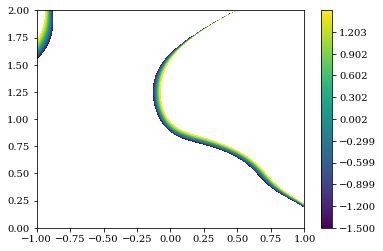

In [27]:
plot_contour(mueller, [-1, 1], [0, 2])

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tfd = tf.contrib.distributions
tfb = tfd.bijectors

AttributeError: module 'tensorflow' has no attribute 'contrib'